#### A quick recap of what's done on MLP part of the modelling

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/suvigyajain0101/NLP/llms/LLMs/names.txt

--2023-05-10 22:20:03--  https://raw.githubusercontent.com/suvigyajain0101/NLP/llms/LLMs/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-05-10 22:20:03 (6.58 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt').read().splitlines()
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [7]:
# Build vocab of characters and mapping to and from integers
chars = sorted(list(set(''.join(words))))
assert len(chars) == 26

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

print(stoi)
print(itos)
print(vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [8]:
import random

block_size = 3

def build_dataset(words):
  
  X, Y = [], []

  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)

  return X, Y

# Random shuffle of words
random.seed(42)
random.shuffle(words)
# Training data -> 80%, Val data -> 10%, testing data -> 10%
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

print('Training Data Size: ', len(X_train))
print('Validation Data Size: ', len(X_val))
print('Testing Data Size: ', len(X_test))

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])
Training Data Size:  182580
Validation Data Size:  22767
Testing Data Size:  22799


In [16]:
n_embd = 10
n_hidden = 200

# First let re-initialize the params
g = torch.Generator().manual_seed(10)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

Total trainable parameters:  11897


In [17]:
batch_size = 32
max_steps = 200000
lossi = []


for k in range(max_steps):

  # Minibatch index
  ix = torch.randint(0, X_train.shape[0], (batch_size,))


  # Forward Pass
  emb = C[X_train[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, n_embd * block_size) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[ix]) # Need to update target dataset as well

  if k%10000 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())

Epoch 0 -> Loss = 27.917713165283203 
Epoch 10000 -> Loss = 2.371678352355957 
Epoch 20000 -> Loss = 2.149704933166504 
Epoch 30000 -> Loss = 2.413130283355713 
Epoch 40000 -> Loss = 2.411926507949829 
Epoch 50000 -> Loss = 2.2060375213623047 
Epoch 60000 -> Loss = 2.778703451156616 
Epoch 70000 -> Loss = 2.1699323654174805 
Epoch 80000 -> Loss = 2.8056716918945312 
Epoch 90000 -> Loss = 2.737464666366577 
Epoch 100000 -> Loss = 2.6630966663360596 
Epoch 110000 -> Loss = 2.2565131187438965 
Epoch 120000 -> Loss = 2.132328987121582 
Epoch 130000 -> Loss = 2.009320020675659 
Epoch 140000 -> Loss = 1.9073455333709717 
Epoch 150000 -> Loss = 2.0356671810150146 
Epoch 160000 -> Loss = 2.605919122695923 
Epoch 170000 -> Loss = 1.9729880094528198 
Epoch 180000 -> Loss = 2.278879404067993 
Epoch 190000 -> Loss = 2.266892910003662 


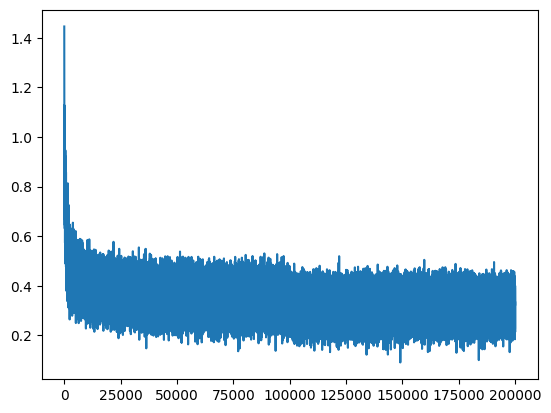

In [18]:
plt.plot(lossi)

In [21]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
  '''Function returns split level loss'''
  x, y = {
      'train': (X_train, Y_train),
      'val': (X_val, Y_val),
      'test': (X_test, Y_test)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)

  h0 = embcat @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.105377197265625
val 2.1447317600250244


In [22]:
g = torch.Generator().manual_seed(10)

for _ in range(20):

  out = []
  context = [0]*block_size

  while True:
    emb = C[torch.tensor([context])]
    h0 = emb.view(1, -1) @ W1 + b1
    h = torch.tanh(h0)
    logits = h @ W2 + b2
    probs = torch.softmax(logits, dim=1)

    ix = torch.multinomial(probs, 1, generator=g).item()
    context = context[1:] + [ix]

    out.append(itos[ix])

    if ix == 0:
      break
      
  print(''.join(out))

pro.
ehle.
meiyan.
nandlomrina.
coptider.
quin.
dana.
uej.
cimianna.
emah.
juan.
ariza.
alareolynn.
aury.
kei.
riya.
thika.
nes.
marshan.
aubrensietta.


Few observations- 

1. Intial loss of the model is very high. For a naive model, this should be close to 3.2 - Negative log of probability, which is 1/27. This has to do with the random initialization. Initial values are so far off the reality (or the model is so confidently wrong!), that we are getting such a high number 